Today we will use the models provided in python's arch package to forecast the next X days of volatility of a stock (as obtained from yahoo, below). We will train and fit the model for highest accuracy.

All testing will use an expanding window for historical data, meaning that the amount of information available to the algorithm will increase as it moves forward in time. Though we will use all historical data available, for computational efficiency we will limit predictions to the most recent quarter (60 trading days).

resources:
- http://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html
- https://vlab.stern.nyu.edu/analysis/VOL.SPY%3AUS-HL.MEM

In [58]:
import datetime as dt
import sys

import numpy as np
import pandas as pd
import pandas_datareader.data as web
import sklearn.metrics as skm

from arch import arch_model

start = dt.datetime(2000,1,1)
end = dt.datetime(2017,1,30)
sp500 = web.get_data_yahoo('SPY', start=start, end=end) #^GSPC
pct_returns = 100 * sp500['Adj Close'].pct_change().dropna()
returns = 100 * (np.log(sp500['Adj Close']) - np.log(sp500['Adj Close'].shift(1))).dropna()

In [59]:
returns.head()

Date
2000-01-04   -3.989132
2000-01-05    0.178730
2000-01-06   -1.620197
2000-01-07    5.645237
2000-01-10    0.342466
Name: Adj Close, dtype: float64

In [61]:
am = arch_model(returns, p=1, o=0, q=1)
algo_name = "garch"

In [62]:
index = returns.index
most_recent_x_days = 250 # 60 for a quarter # 250 for a year
horizon = 5
start_loc = 0
end_loc = index.size - most_recent_x_days - horizon #np.where(index >= '2000-2-5')[0].min()
forecasts = {}
# Change to encompass
X = 20
for i in range(most_recent_x_days):
    sys.stdout.write('.')
    sys.stdout.flush()
    res = am.fit(last_obs=i+end_loc, disp='off')
    temp = res.forecast(horizon=horizon).variance
    fcast = temp.iloc[i+end_loc-1]
    forecasts[fcast.name] = fcast
    
predictions = pd.DataFrame(forecasts).T
print(predictions.tail())

..........................................................................................................................................................................................................................................................                 h.1       h.2       h.3       h.4       h.5
2017-01-13  0.298784  0.315764  0.332446  0.348835  0.364938
2017-01-17  0.301862  0.318766  0.335375  0.351693  0.367725
2017-01-18  0.289715  0.306791  0.323569  0.340055  0.356253
2017-01-19  0.295411  0.312368  0.329030  0.345401  0.361487
2017-01-20  0.291330  0.308327  0.325029  0.341440  0.357566


http://scikit-learn.org/stable/modules/model_evaluation.html
Evaluating the accuracy of arch models is difficult because volatility is not observable in real time. Since we are trying to evaluate the accuracy of an X-day forecast of volatility, we will use the realized volatility on the same time horizon as our "reality."

We will use the following metrics to evaluate the accuracy of our models:
- Explained Variance Score
- Mean Absolute Error
- Mean Squared Error
- Median Absolute Error
- R^2 (Coefficient of Determination)

In [63]:
# actual = returns[end_loc:(end_loc+most_recent_x_days)]
actual = pd.rolling_std(np.log(1+returns), window=(horizon+1))*np.sqrt(horizon+1)
actual = actual[end_loc:(end_loc+most_recent_x_days)]
predicted = predictions["h."+str(horizon)]
compare = pd.DataFrame({"actual":actual, "predicted":predicted.values}).dropna()
accuracy = pd.DataFrame(index=[algo_name],
    data={"explained_variance_score": skm.explained_variance_score(compare['actual'], compare['predicted']),
          "mean_absolute_error": skm.mean_absolute_error(compare['actual'], compare['predicted']),
          "mean_squared_error": skm.mean_squared_error(compare['actual'], compare['predicted']),
          "median_absolute_error": skm.median_absolute_error(compare['actual'], compare['predicted']),
          "r2_score": skm.r2_score(compare['actual'], compare['predicted'])
    })


In [64]:
accuracy.T

,garch
explained_variance_score,0.055523
mean_absolute_error,0.868862
mean_squared_error,1.414519
median_absolute_error,0.514779
r2_score,-0.943817


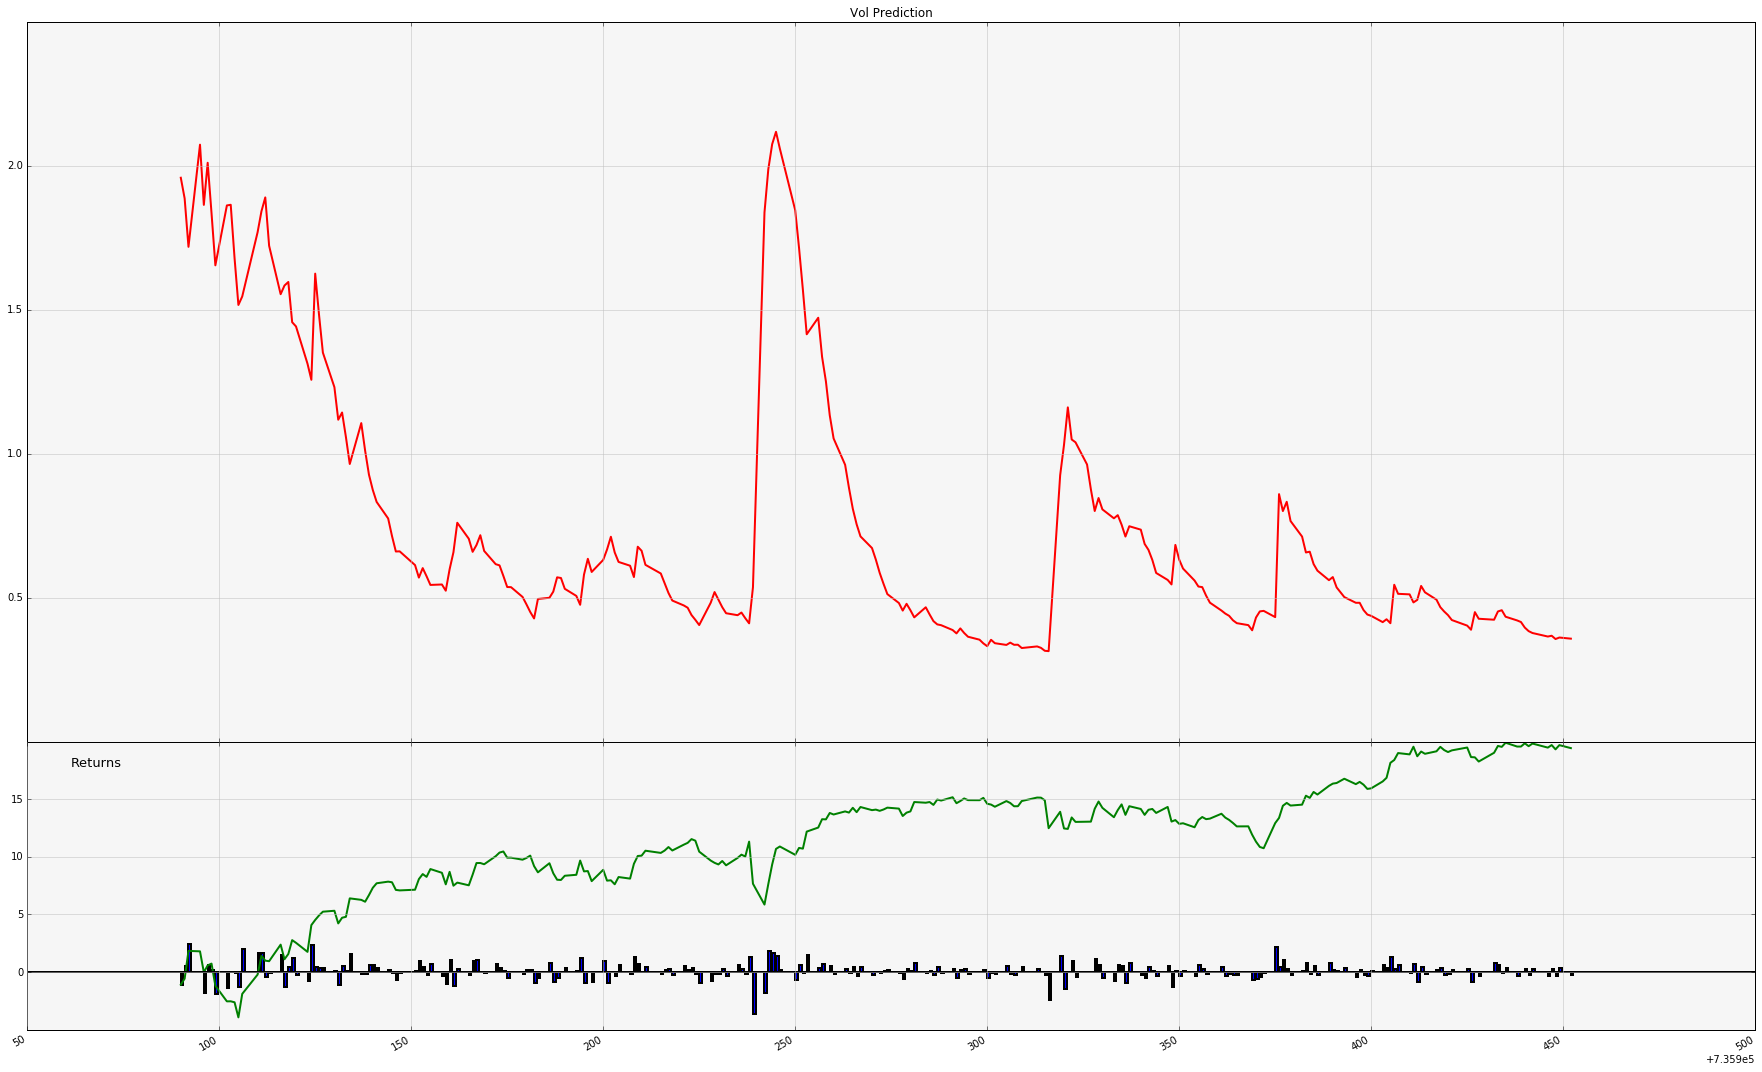

In [65]:
# Next we plot the indicator against our asset's prices
import matplotlib
import matplotlib.colors as colors
import matplotlib.finance as finance
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 20.0)

plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 13
left, width = 0.1, 0.8
# rect1 = [left, 0.7, width, 0.2]
rect2 = [left, 0.3, width, 0.5]
rect3 = [left, 0.1, width, 0.2]


fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color
fillcolor = 'darkslategrey'

# ax1 = fig.add_axes(rect1, axisbg=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, axisbg=axescolor)#, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, axisbg=axescolor, sharex=ax2)

vol_pred = predicted
raw_returns = returns[end_loc:(end_loc+most_recent_x_days)]
chart_index = mdates.date2num(raw_returns.index.to_pydatetime())
ax2.set_title('Vol Prediction')  # ('%s Stock Price' % asset)

# plot the price and volume data
ax2.plot(chart_index, vol_pred, color="red", lw=2)

props = font_manager.FontProperties(size=10)
# leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
# leg.get_frame().set_alpha(0.5)


ax2t.set_yticks([])


# Plot the indicator
ax3.bar(chart_index, height=raw_returns, width = 1/1.5, color='blue', lw=2)
ax3.plot(chart_index, raw_returns.cumsum(), color='green', lw=2) 
ax3.axhline(y=0, color='black', lw=2)

ax3.text(0.025, 0.95, 'Returns', va='top',
         transform=ax3.transAxes, fontsize=textsize)

# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax2, ax2t, ax3: #ax1, 
    if ax != ax3:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
#ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
#ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()

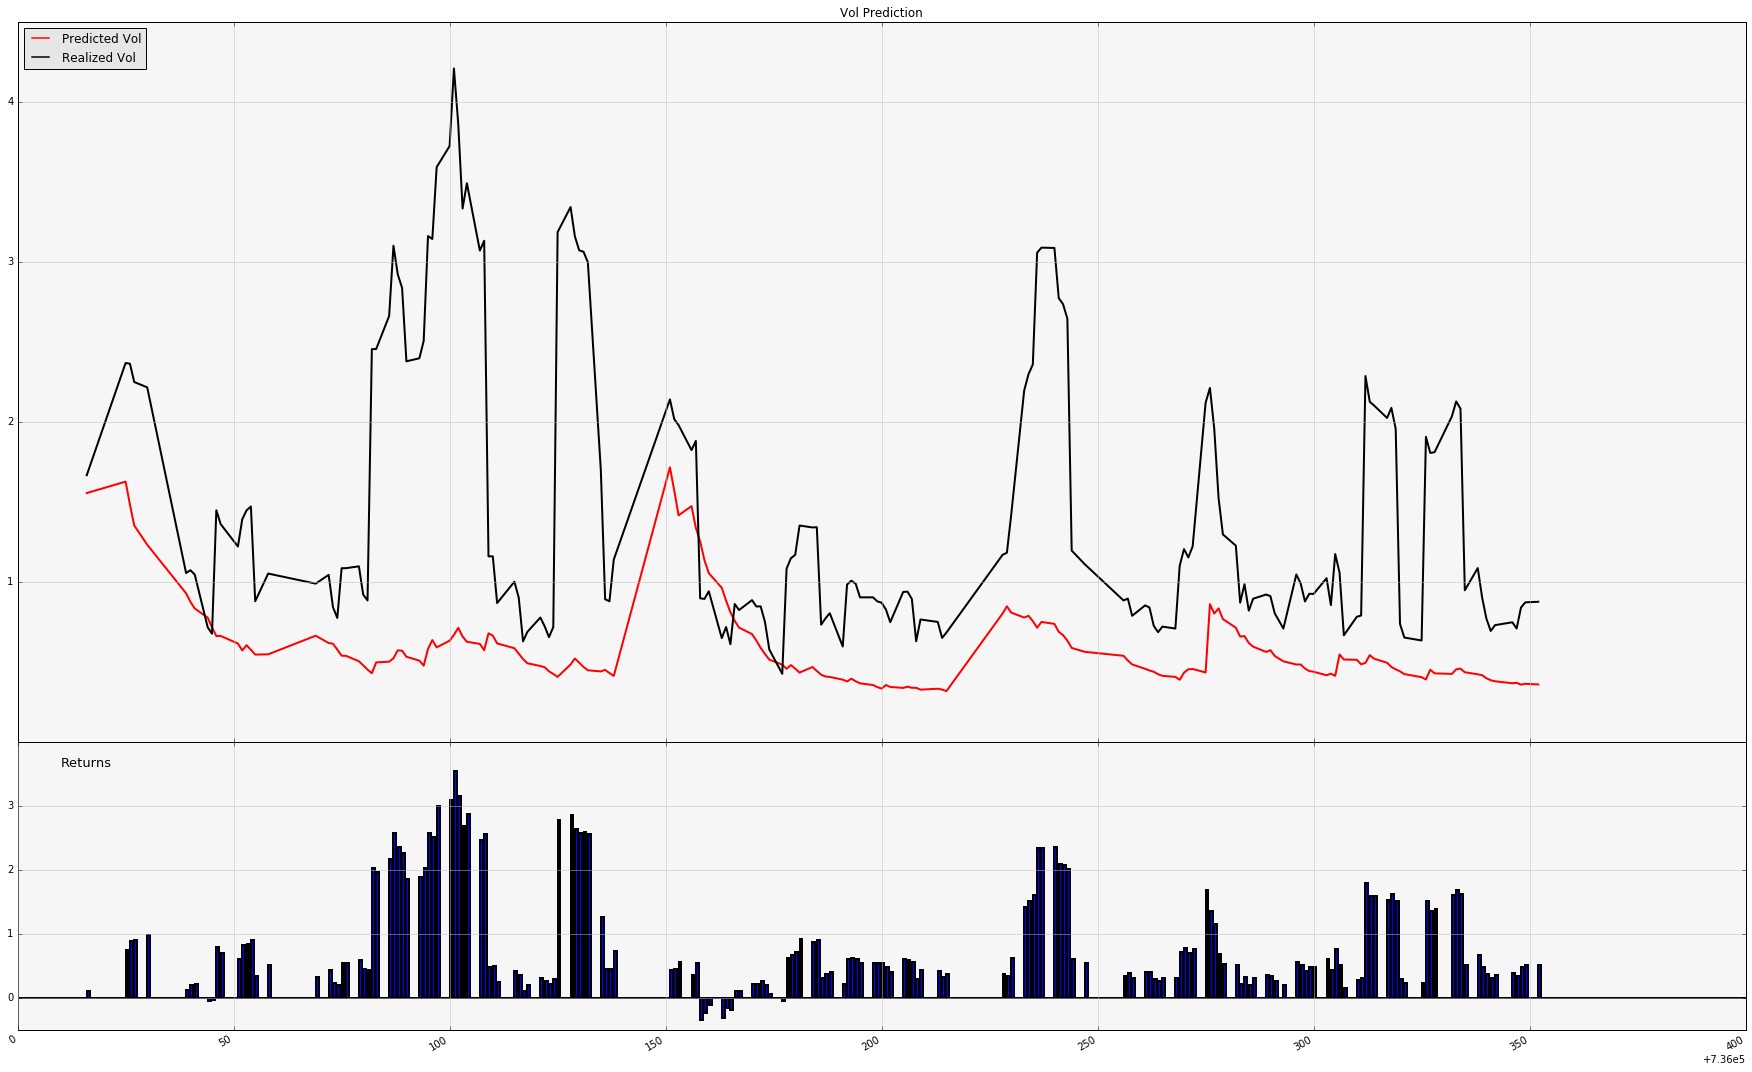

In [66]:
# Next, we plot the daily prediction and the actual volatility measure
# along with the margin of error

plt.rcParams['figure.figsize'] = (30.0, 20.0)

plt.rc('axes', grid=True)
plt.rc('grid', color='0.75', linestyle='-', linewidth=0.5)

textsize = 13
left, width = 0.1, 0.8
# rect1 = [left, 0.7, width, 0.2]
rect2 = [left, 0.3, width, 0.5]
rect3 = [left, 0.1, width, 0.2]


fig = plt.figure(facecolor='white')
axescolor = '#f6f6f6'  # the axes background color
fillcolor = 'darkslategrey'

# ax1 = fig.add_axes(rect1, axisbg=axescolor)  # left, bottom, width, height
ax2 = fig.add_axes(rect2, axisbg=axescolor)#, sharex=ax1)
ax2t = ax2.twinx()
ax3 = fig.add_axes(rect3, axisbg=axescolor, sharex=ax2)

vol_pred = compare["predicted"]
vol_act = compare["actual"]
# raw_returns = returns[end_loc:(end_loc+most_recent_x_days)]
chart_index = mdates.date2num(compare.index.to_pydatetime())
ax2.set_title('Vol Prediction')  # ('%s Stock Price' % asset)

# plot the price and volume data
ax2.plot(chart_index, vol_pred, color="red", lw=2, label='Predicted Vol')
ax2.plot(chart_index, vol_act, color="black", lw=2, label='Realized Vol')
legend = ax2.legend(loc='upper left')
props = font_manager.FontProperties(size=10)
# leg = ax2.legend(loc='center left', shadow=True, fancybox=True, prop=props)
# leg.get_frame().set_alpha(0.5)


ax2t.set_yticks([])


# Plot the indicator
ax3.bar(chart_index, height=(vol_act-vol_pred), width = 1/1.5, color='blue', lw=2)
ax3.axhline(y=0, color='black', lw=2)

ax3.text(0.025, 0.95, 'Returns', va='top',
         transform=ax3.transAxes, fontsize=textsize)


# The frame is matplotlib.patches.Rectangle instance surrounding the legend.
frame = legend.get_frame()
frame.set_facecolor('0.90')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')

for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width

# turn off upper axis tick labels, rotate the lower ones, etc
for ax in ax2, ax2t, ax3: #ax1, 
    if ax != ax3:
        for label in ax.get_xticklabels():
            label.set_visible(False)
    else:
        for label in ax.get_xticklabels():
            label.set_rotation(30)
            label.set_horizontalalignment('right')

    ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


class MyLocator(mticker.MaxNLocator):
    def __init__(self, *args, **kwargs):
        mticker.MaxNLocator.__init__(self, *args, **kwargs)

    def __call__(self, *args, **kwargs):
        return mticker.MaxNLocator.__call__(self, *args, **kwargs)

# at most 5 ticks, pruning the upper and lower so they don't overlap
# with other ticks
#ax2.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))
#ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='both'))

ax2.yaxis.set_major_locator(MyLocator(5, prune='both'))
ax3.yaxis.set_major_locator(MyLocator(5, prune='both'))

plt.show()

In [67]:
index = returns.index
now_forecasts = {}
end_loc = index.size
res = am.fit(last_obs=end_loc, disp='off')
temp = res.forecast(horizon=5).variance
fcast = temp.iloc[end_loc-1]
now_forecasts[fcast.name] = fcast
current_predictions = pd.DataFrame(now_forecasts).T
print(current_predictions.tail())

                 h.1       h.2       h.3       h.4      h.5
2017-01-30  0.358162  0.373955  0.389475  0.404725  0.41971


In [68]:
annualized_vol = np.sqrt(252*current_predictions)
day_ahead = annualized_vol[["h.1"]]
week_ahead = annualized_vol[["h.5"]]

In [69]:
day_ahead

,h.1
2017-01-30,9.500358


In [71]:
week_ahead

,h.5
2017-01-30,10.284307


In [72]:
returns.tail()

Date
2017-01-24    0.639126
2017-01-25    0.861830
2017-01-26   -0.104600
2017-01-27   -0.157103
2017-01-30   -0.622099
Name: Adj Close, dtype: float64